# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Implementation Details

- Actor-critic
- On Policy

### Sampling
- [ ] Mini-batch to update 'average' gradient
- [ ] Experience Replay for Random Sampling
- [ ] Importance Sampling
    
### Deterministic Policy Gradient
- [ ] DDPG
- [ ] MADDPG

### Stability and Reducing Variance
- [x] Gradient clipping
- [ ] Normalized Reward/Advantage
- [ ] Target Network
- [ ] TRPO
- [ ] PPO

### Multiprocessing
- [ ] Synchronous Training (A2C)
- [x] Asynchronous Training (A3C)

### Applied Training Methods:
- [ ] Self-play
- [ ] Batch Policy

## Notes

- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs

- This notebook does not include:
    - Simulation with RL policy
        - The simulation can be done using policy_RL.py
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc
- https://github.com/lilianweng/deep-reinforcement-learning-gym/blob/master/playground/policies/actor_critic.py (source)
- https://github.com/spro/practical-pytorch/blob/master/reinforce-gridworld/reinforce-gridworld.ipynb

## TODO:

- Research on '_bootstrap_' instead of end-reward
- Add global step
- Think about adding discont to advantage
- Normalize reward?
- Record method in network

!rm -rf logs/A3C_Navigation/ model/A3C_Navigation

In [1]:
TRAIN_NAME='A3C_Navigation'
LOG_PATH='./logs/'+TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME
RENDER_PATH='./render/' + TRAIN_NAME
GPU_CAPACITY=0.25 # gpu capacity in percentage

In [2]:
import os
import configparser

import signal
import threading
import multiprocessing

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random
import math

# the modules that you can use to generate the policy. 
import policy.random
import policy.roomba
import policy.policy_RL
import policy.zeros

# Data Processing Module
from utility.dataModule import one_hot_encoder as one_hot_encoder
from utility.utils import MovingAverage as MA
from utility.utils import Experience_buffer, discount_rewards
from utility.buffer import Trajectory

from network.ActorCritic import ActorCritic as AC

import imageio

%load_ext autoreload
%autoreload 2

## Hyperparameters

In [3]:
# Importing global configuration
config = configparser.ConfigParser()
config.read('config.ini')

## Environment
action_space = config.getint('DEFAULT','ACTION_SPACE')
n_agent = config.getint('DEFAULT','NUM_AGENT')
map_size = config.getint('DEFAULT','MAP_SIZE')
vision_range = config.getint('DEFAULT','VISION_RANGE')

## Training
total_episodes = config.getint('TRAINING','TOTAL_EPISODES')
max_ep = config.getint('TRAINING','MAX_STEP')
critic_beta = config.getfloat('TRAINING', 'CRITIC_BETA')
entropy_beta = config.getfloat('TRAINING', 'ENTROPY_BETA')
gamma = config.getfloat('TRAINING', 'DISCOUNT_RATE')

decay_lr = config.getboolean('TRAINING','DECAYING_LR')
lr_a = 5e-5#config.getfloat('TRAINING','LR_ACTOR')
lr_c = 2e-4#config.getfloat('TRAINING','LR_CRITIC')

## Save/Summary
save_network_frequency = config.getint('TRAINING','SAVE_NETWORK_FREQ')
save_stat_frequency = config.getint('TRAINING','SAVE_STATISTICS_FREQ')
save_render_frequency = 2000
moving_average_step = config.getint('TRAINING','MOVING_AVERAGE_SIZE')

## GPU
gpu_capacity = config.getfloat('GPU_CONFIG','GPU_CAPACITY')
gpu_allowgrow = config.getboolean('GPU_CONFIG', 'GPU_ALLOWGROW')

In [4]:
# Local configuration parameters
update_frequency = 150
#po_transition = 50000 # Partial observable

# Env Settings
vision_dx, vision_dy = 2*vision_range+1, 2*vision_range+1
nchannel = 6
in_size = [None,vision_dx,vision_dy,nchannel]
nenv = 8#(int) (multiprocessing.cpu_count())

# Asynch Settings
global_scope = 'global'

## Environment Setting

In [5]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
#Create a directory to save episode playback gifs to
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
    
if not os.path.exists(RENDER_PATH):
    os.makedirs(RENDER_PATH)

## A3C Network Structure

![Network Structure](https://cdn-images-1.medium.com/max/1600/1*YtnGhtSAMnnHSL8PvS7t_w.png)

- Network is given in network.ActorCritic

## Environments

![Environment Interaction Diagram](https://cdn-images-1.medium.com/max/1600/1*Hzql_1t0-wwDxiz0C97AcQ.png)

In [6]:
global_rewards = MA(moving_average_step)
global_ep_rewards = MA(moving_average_step)
global_length = MA(moving_average_step)
global_succeed = MA(moving_average_step)
global_episodes = 0

# Launch the session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=GPU_CAPACITY, allow_growth=True)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
progbar = tf.keras.utils.Progbar(total_episodes,interval=1)

## Worker

In [7]:
class Worker(object):
    def __init__(self, name, globalAC, sess, global_step=0):
        # Initialize Environment worker
        self.env = gym.make("cap-v0").unwrapped
        self.env.reset(map_size=map_size,
                       policy_red=policy.zeros.PolicyGen(self.env.get_map, self.env.get_team_red),
                       num_blue=4,
                       num_red=0
                      )
        print(f'    env launched: n_red:{len(self.env.get_team_red)}, n_blue:{len(self.env.get_team_blue)}')
                     
        self.name = name
        
        # Create AC Network for Worker
        self.AC = AC(in_size=in_size,
                     action_size=action_space,
                     decay_lr=decay_lr,
                     lr_actor=lr_a,
                     lr_critic=lr_c,
                     grad_clip_norm=0,
                     scope=self.name,
                     global_step=global_step,
                     initial_step=0,
                     entropy_beta = 0.01,
                     sess=sess,
                     global_network=global_ac)
        
        self.sess=sess
        
    def get_action(self, states):
        actions, values = [], []
        for state in states:
            feed_dict = {self.AC.state_input : state[np.newaxis,:]}
            action, value = self.AC.run_network(feed_dict)
            actions.append(action[0])
            values.append(value[0])
#        feed_dict = {self.AC.state_input : s}
#        a1, v1, _ = self.AC.run_network(feed_dict)
        
#        return a1, v1, _
        return actions, values

    def work(self, saver, writer):
        global global_rewards, global_ep_rewards, global_episodes, global_length, global_succeed
        total_step = 1
                
        # loop
        with self.sess.as_default(), self.sess.graph.as_default():
            while not coord.should_stop() and global_episodes < total_episodes:
                s0 = self.env.reset(num_blue=4, num_red=0)
                s0 = one_hot_encoder(self.env._env, self.env.get_team_blue, vision_range)
                
                # parameters 
                ep_r = 0 # Episodic Reward
                prev_r = 0
                was_alive = [ag.isAlive for ag in self.env.get_team_blue]

                trajs = [Trajectory(depth=4) for _ in range(n_agent)]
                
                # Bootstrap
                a1, v1 = self.get_action(s0)
                
                # Recording Frames
                frames = []
                render = global_episodes % save_render_frequency == 0 and global_episodes>0
                
                for step in range(max_ep+1):
                    if render:
                        frames.append(self.env.render(mode='rgb_array'))
                        self.env.viewer.window.set_visible(False)
                    a, v0 = a1, v1
                    
                    s1, rc, d, _ = self.env.step(a)
                    s1 = one_hot_encoder(self.env._env, self.env.get_team_blue, vision_range)
                    is_alive = [ag.isAlive for ag in self.env.get_team_blue]
                    r = (rc - prev_r-0.5)

                    if step == max_ep and d == False:
                        r = -100
                        rc = -100
                        d = True

                    r /= 100.0
                    ep_r += r

                    if d:
                        v1 = [0.0 for _ in range(len(self.env.get_team_blue))]
                    else:
                        a1, v1 = self.get_action(s1)

                    # push to buffer
                    for idx, agent in enumerate(self.env.get_team_blue):
                        if was_alive[idx]:
                            trajs[idx].append([s0[idx],
                                               a[idx],
                                               r,
                                               v0[idx]
                                              ])

                    if total_step % update_frequency == 0 or d:
                        aloss, closs, etrpy, feed_dict = self.train(trajs, sess, v1)
                        trajs = [Trajectory(depth=5) for _ in range(n_agent)]

                    # Iteration
                    prev_r = rc
                    was_alive = is_alive
                    s0=s1
                    total_step += 1

                    if d:
                        break
                        
                if render:
                    imageio.mimsave(RENDER_PATH+f'/ep{global_episodes}_render.gif', frames)
                global_ep_rewards.append(ep_r)
                global_rewards.append(rc)
                global_length.append(step)
                global_succeed.append(self.env.blue_win)
                global_episodes += 1
                self.sess.run(global_step_next)
                progbar.update(global_episodes)
                if global_episodes % save_stat_frequency == 0 and global_episodes != 0:
                    summary_ = sess.run(merged_summary_op, feed_dict)
                    summary = tf.Summary()
                    summary.value.add(tag='Records/mean_reward', simple_value=global_rewards())
                    summary.value.add(tag='Records/mean_length', simple_value=global_length())
                    summary.value.add(tag='Records/mean_succeed', simple_value=global_succeed())
                    summary.value.add(tag='Records/mean_episode_reward', simple_value=global_ep_rewards())
                    summary.value.add(tag='summary/Entropy', simple_value=etrpy)
                    summary.value.add(tag='summary/actor_loss', simple_value=aloss)
                    summary.value.add(tag='summary/critic_loss', simple_value=closs)
                    writer.add_summary(summary,global_episodes)
                    writer.add_summary(summary_,global_episodes)

                    writer.flush()
                if global_episodes % save_network_frequency == 0 and global_episodes != 0:
                    saver.save(self.sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_episodes)

    def train(self, trajs, sess, bootstrap=0.0):
        buffer_s, buffer_a, buffer_tdtarget, buffer_adv = [], [], [], []
        for idx, traj in enumerate(trajs):
            if len(traj) == 0:
                continue
            observations = traj[0]
            actions = traj[1]
            rewards = np.array(traj[2])
            values = np.array(traj[3])
            
            value_ext = np.append(values, [bootstrap[idx]])
            td_target  = rewards + gamma * value_ext[1:]
            advantages = rewards + gamma * value_ext[1:] - value_ext[:-1]
            advantages = discount_rewards(advantages,gamma)
            
            buffer_s.extend(observations)
            buffer_a.extend(actions)
            buffer_tdtarget.extend(td_target.tolist())
            buffer_adv.extend(advantages.tolist())


        buffer_s, buffer_a, buffer_tdtarget, buffer_adv = np.stack(buffer_s), np.array(buffer_a), np.array(buffer_tdtarget), np.array(buffer_adv)
        feed_dict = {
            self.AC.state_input : buffer_s,
            self.AC.action_ : buffer_a,
            self.AC.td_target_ : buffer_tdtarget,
            self.AC.advantage_ : buffer_adv,
        }

        # Update Buffer
        aloss, closs, etrpy = self.AC.update_global(feed_dict)

        # get global parameters to local ActorCritic 
        self.AC.pull_global()
        
        return aloss, closs, etrpy, feed_dict
    

## Initialization

In [8]:
# Global Network
global_step = tf.Variable(0, trainable=False, name='global_step')
global_step_next = tf.assign_add(global_step, 1)
global_ac = AC(in_size=in_size, action_size=action_space, scope=global_scope, sess=sess, global_step=global_step)

# Local workers
workers = []
# loop for each workers
for idx in range(nenv):
    name = 'W_%i' % idx
    print(f'worker: {name} initializing')
    workers.append(Worker(name, global_ac, sess, global_step=global_step))
saver = tf.train.Saver(max_to_keep=3)
writer = tf.summary.FileWriter(LOG_PATH, sess.graph)
    
ckpt = tf.train.get_checkpoint_state(MODEL_PATH)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")
    
coord = tf.train.Coordinator()
worker_threads = []
global_episodes = sess.run(global_step)

saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_episodes)

# Summarize
for var in tf.trainable_variables(scope=global_scope):
    tf.summary.histogram(var.name, var)
merged_summary_op = tf.summary.merge_all()

worker: W_0 initializing
    env launched: n_red:0, n_blue:4


/home/namsong/anaconda3/envs/py36/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


worker: W_1 initializing
    env launched: n_red:0, n_blue:4
worker: W_2 initializing
    env launched: n_red:0, n_blue:4
worker: W_3 initializing
    env launched: n_red:0, n_blue:4
worker: W_4 initializing
    env launched: n_red:0, n_blue:4
worker: W_5 initializing
    env launched: n_red:0, n_blue:4
worker: W_6 initializing
    env launched: n_red:0, n_blue:4
worker: W_7 initializing
    env launched: n_red:0, n_blue:4
INFO:tensorflow:Restoring parameters from ./model/A3C_Navigation/ctf_policy.ckpt-50000
Load Model :  ./model/A3C_Navigation/ctf_policy.ckpt-50000
INFO:tensorflow:Summary name global/actor/Conv/weights:0 is illegal; using global/actor/Conv/weights_0 instead.
INFO:tensorflow:Summary name global/actor/Conv/biases:0 is illegal; using global/actor/Conv/biases_0 instead.
INFO:tensorflow:Summary name global/actor/Conv_1/weights:0 is illegal; using global/actor/Conv_1/weights_0 instead.
INFO:tensorflow:Summary name global/actor/Conv_1/biases:0 is illegal; using global/actor/

## Train

for worker in workers:
    job = lambda: worker.work(saver, writer)
    t = threading.Thread(target=job)
    t.start()
    worker_threads.append(t)
coord.join(worker_threads)

## Render Simulation

In [9]:
from tqdm import tqdm

env = gym.make("cap-v0").unwrapped
env.reset(map_size=map_size,
          policy_red=policy.zeros.PolicyGen(env.get_map, env.get_team_red),
          num_blue=4,
          num_red=0
          )
print(f'env launched: n_red:{len(env.get_team_red)}, n_blue:{len(env.get_team_blue)}')

def get_action(states):
    feed_dict = {global_ac.state_input : states}
    a1, v1 = global_ac.run_network(feed_dict)

    return a1, v1

def render_run(n_episode):
    frames = []
    for ep in tqdm(range(n_episode)):
        s0 = env.reset(num_blue=4, num_red=0,
                       policy_red=policy.zeros.PolicyGen(env.get_map, env.get_team_red))
        s0 = one_hot_encoder(env._env, env.get_team_blue, vision_range)

        # parameters 
        ep_r = 0 # Episodic Reward
        prev_r = 0 # Previous Reward

        # Bootstrap
        a1, v1 = get_action(s0)

        for step in range(max_ep+1):
            frames.append(env.render(mode='rgb_array'))
            env.viewer.window.set_visible(False)
            a, v0 = a1, v1

            s1, rc, d, _ = env.step(a)
            s1 = one_hot_encoder(env._env, env.get_team_blue, vision_range)
            r = (rc - prev_r-0.5)

            if step == max_ep and d == False:
                r = -100
                rc = -100
                d = True
            r /= 100.0
            ep_r += r

            if not d:
                a1, v1 = get_action(s1)

            # Iteration
            prev_r = rc
            s0=s1

            if d:
                break

    imageio.mimsave(RENDER_PATH+f'/series_ep{n_episode}_render.gif', frames)
    print('render done')


env launched: n_red:0, n_blue:4


Render_Episode = 20
render_run(Render_Episode)
Render_Episode = 50
render_run(Render_Episode)

## Statistics

In [10]:
success_rate = []  # based on env.blue_won
mean_reward = []
episode_length = []
survival_rate = []

def statistics(n_episode):
    frames = []
    for ep in tqdm(range(n_episode)):
        s0 = env.reset(num_blue=4,
                       num_red=0,
                       policy_red=policy.zeros.PolicyGen(env.get_map, env.get_team_red))
        s0 = one_hot_encoder(env._env, env.get_team_blue, vision_range)

        # parameters 
        ep_r = 0 # Episodic Reward
        prev_r = 0 # Previous Reward

        # Bootstrap
        a1, v1 = get_action(s0)

        for step in range(max_ep+1):
            a, v0 = a1, v1

            s1, rc, d, _ = env.step(a)
            s1 = one_hot_encoder(env._env, env.get_team_blue, vision_range)
            r = (rc - prev_r-0.5)

            if step == max_ep and d == False:
                r = -100
                rc = -100
                d = True
            r /= 100.0
            ep_r += r

            if not d:
                a1, v1 = get_action(s1)

            # Iteration
            prev_r = rc
            s0=s1

            if d:
                success_rate.append(env.blue_win)
                mean_reward.append(r)
                episode_length.append(step)
                survival_rate.append(sum([ag.isAlive for ag in env.get_team_blue])/n_agent)
                break


In [11]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [12]:
statistics(1000)

100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s]


mean: 0.987, std: 0.11327400407860577


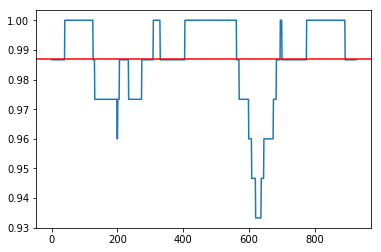

In [13]:
mean = np.mean(success_rate)
std = np.std(success_rate)
print(f'mean: {mean}, std: {std}')

plt.plot(moving_average(success_rate,n=75))
plt.axhline(mean, color='r')

mean: 0.9690649999999996, std: 0.2259816381368185


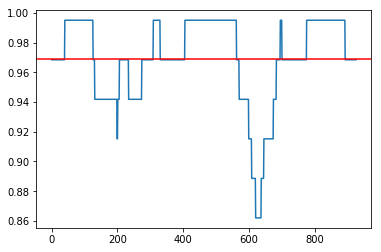

In [14]:
mean = np.mean(mean_reward)
std = np.std(mean_reward)
print(f'mean: {mean}, std: {std}')

plt.plot(moving_average(mean_reward,n=75))
plt.axhline(mean,color='r')

mean: 14.02, std: 19.811451234071672


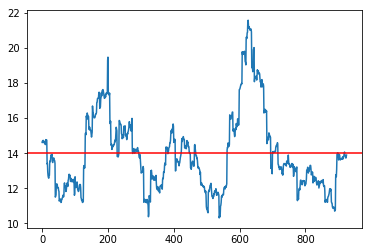

In [15]:
mean = np.mean(episode_length)
std = np.std(episode_length)
print(f'mean: {mean}, std: {std}')

plt.plot(moving_average(episode_length,n=75))
plt.axhline(mean,color='r')

mean: 1.0, std: 0.0


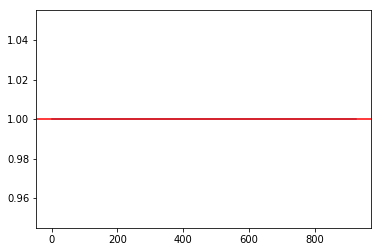

In [16]:
mean = np.mean(survival_rate)
std = np.std(survival_rate)
print(f'mean: {mean}, std: {std}')

plt.plot(moving_average(survival_rate,n=75))
plt.axhline(mean,color='r')